In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
!curl -O  https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   1588      0  0:00:01  0:00:01 --:--:--  1593
100  2036  100  2036    0     0   1587      0  0:00:01  0:00:01 --:--:--  1591


In [3]:
df=pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [4]:
df['LogPassengers']=np.log(df['Passengers'])

In [5]:
Ntest=12
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [6]:
# boolean series to index df rows
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [7]:
df['DiffLogPassengers']=df['LogPassengers'].diff()

In [8]:
# Make supervised dataset
series=df['DiffLogPassengers'].dropna().to_numpy()

T=10
X=[]
Y=[]
for t in range(len(series)-T):
    x=series[t:t+T]
    X.append(x)
    y=series[t+T]
    Y.append(y)
X=np.array(X).reshape(-1,T,1)
Y=np.array(Y)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [9]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

In [11]:
# RNN
i = Input(shape=(T,1))
x=LSTM(24)(i)
x=Dense(1)(x)
model=Model(i,x)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(
loss='mse',
optimizer='adam')

In [14]:
r=model.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest))

Epoch 1/100
4/4 [==============================] - 6s 355ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 3/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 4/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 5/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 6/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 8/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 9/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 10/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 11/100
4/4 [

Epoch 84/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 85/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 86/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 87/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 88/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 89/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 90/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 91/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 92/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 93/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 94/1

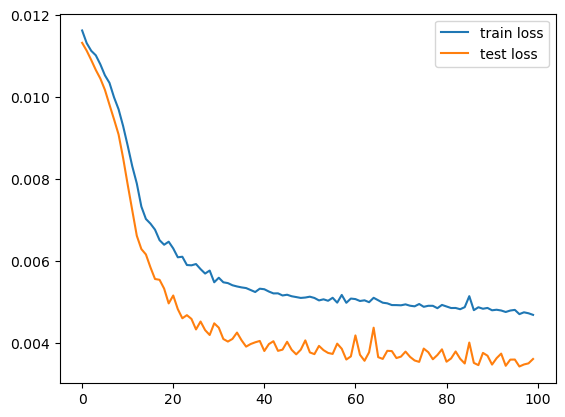

In [15]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend();

In [16]:
train_idx[:T+1]=False # First T+1 values are not predictable

In [17]:
Ptrain=model.predict(Xtrain).flatten()
Ptest=model.predict(Xtest).flatten()

1/1 [==============================] - 0s 40ms/step


In [18]:
# Needed to compute un differenced predictions
df['ShiftLogPassengers']=df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [19]:
# Last-known train value
last_train=train.iloc[-1]['LogPassengers']

In [20]:
# 1-step forecast
df.loc[train_idx,'1step_train']=prev[train_idx]+Ptrain
df.loc[test_idx,'1step_test']=prev[test_idx]+Ptest

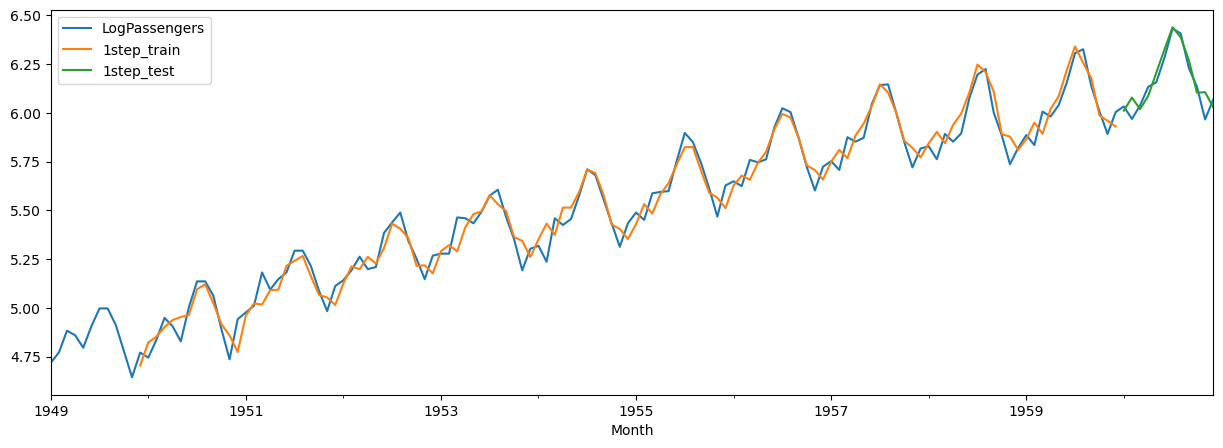

In [21]:
# plot 1-step forecast
df[['LogPassengers','1step_train','1step_test']].plot(figsize=(15,5));

In [22]:
# multi-step forecast
multistep_predictions=[]

# first test input
last_x=Xtest[0]

while len(multistep_predictions)<Ntest:
    p=model.predict(last_x.reshape(1,-1,1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)

    # Make the new input
    last_x=np.roll(last_x,-1)
    last_x[-1]=p

1/1 [==============================] - 0s 44ms/step


In [23]:
# save multi-step forecast to dataframe
df.loc[test_idx,'multistep']=last_train+np.cumsum(multistep_predictions)

<Axes: xlabel='Month'>

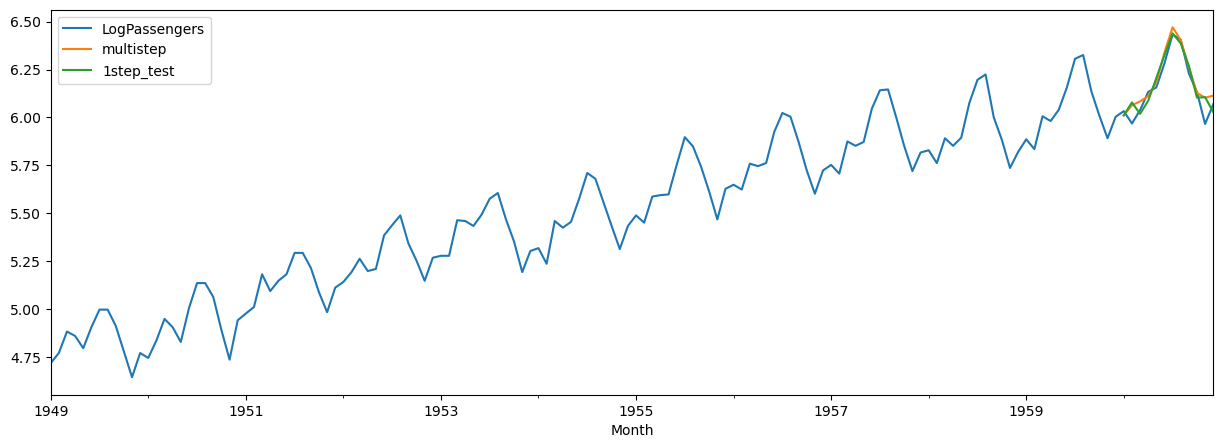

In [24]:
# plot 1-step and multi-step forecast
df[['LogPassengers','multistep','1step_test']].plot(figsize=(15,5))

In [35]:
# make multi-output supervised dataset
Tx=T
Ty=Ntest
X=[]
Y=[]
for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)
    
X=np.array(X).reshape(-1,Tx,1)
Y=np.array(Y).reshape(-1,Ty)
N=len(X)
print('X.shape',X.shape,'Y.shape',Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [36]:
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

In [37]:
# RNN
i=Input(shape=(Tx,1))
x=LSTM(24,return_sequences=True)(i)
x=GlobalMaxPooling1D()(x)
x=Dense(Ty)(x)
model=Model(i,x)

In [38]:
check_point=ModelCheckpoint(
'best_model.h5',monitor='val_loss',save_best_only=True)

In [39]:
model.compile(
loss='mse',
optimizer='adam')

In [40]:
r=model.fit(
Xtrain_m,
Ytrain_m,
epochs=300,
validation_data=(Xtest_m,Ytest_m),
callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 5s 330ms/step - loss: 0.0115 - val_loss: 0.0118
Epoch 2/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 3/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 4/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 7/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 8/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 9/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 10/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 11/300
4/4 [

Epoch 84/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 85/300
4/4 [==============================] - 0s 44ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 86/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 87/300
4/4 [==============================] - 0s 38ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 88/300
4/4 [==============================] - 0s 47ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 89/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 90/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 91/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 92/300
4/4 [==============================] - 0s 36ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 93/300
4/4 [==============================] - 0s 24ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 94/3

4/4 [==============================] - 0s 38ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 167/300
4/4 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 168/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 169/300
4/4 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 170/300
4/4 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 171/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 172/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 173/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 174/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 175/300
4/4 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 176/300


4/4 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 249/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 250/300
4/4 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 251/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 252/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 253/300
4/4 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 254/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 255/300
4/4 [==============================] - 0s 22ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 256/300
4/4 [==============================] - 0s 35ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 257/300
4/4 [==============================] - 0s 23ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 258/300


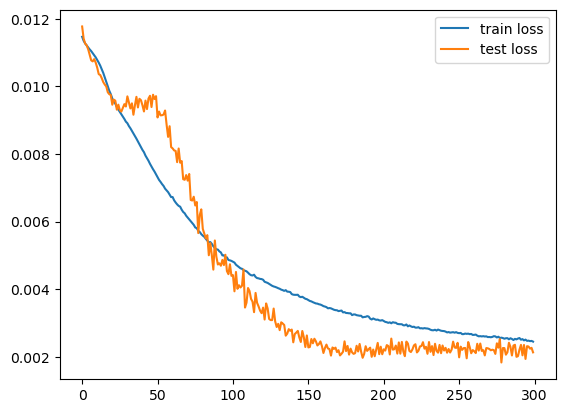

In [41]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend()

In [42]:
Ptrain=model.predict(Xtrain_m)
Ptest=model.predict(Xtest_m)

1/1 [==============================] - 0s 47ms/step


In [43]:
Ptrain.shape,Ptest.shape

((121, 12), (1, 12))

In [44]:
Ptrain=Ptrain[:,0]
Ptest=Ptest[0]

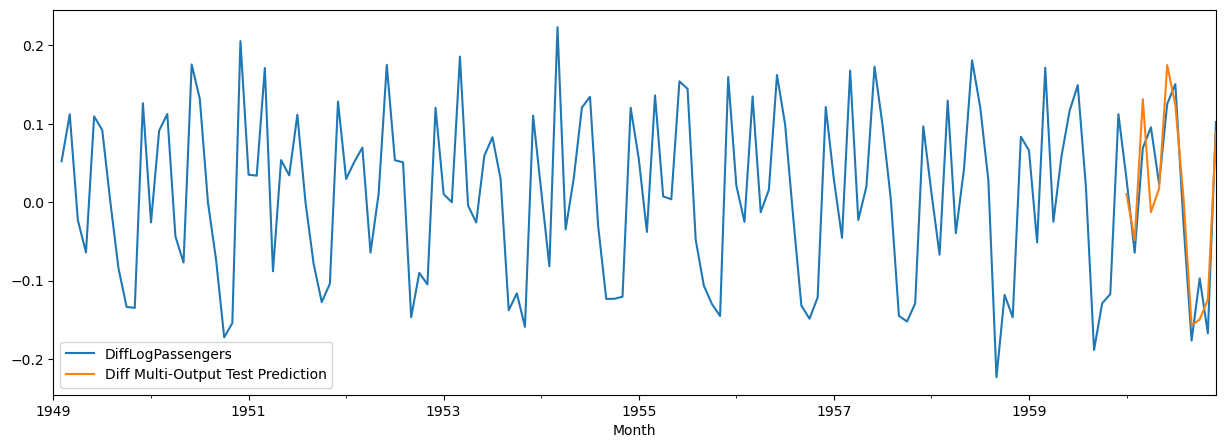

In [45]:
df.loc[test_idx,'Diff Multi-Output Test Prediction']=Ptest
cols=['DiffLogPassengers','Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(15,5));

In [46]:
# save multi-outpur forecast to dataframe
df.loc[test_idx,'multioutput']=last_train+np.cumsum(Ptest)

<Axes: xlabel='Month'>

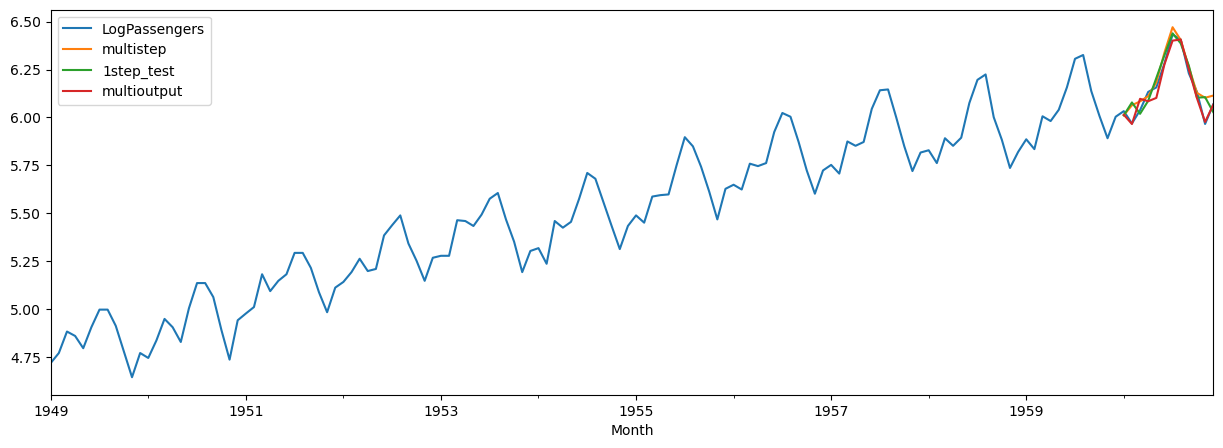

In [47]:
# plot all forecasts
cols=['LogPassengers','multistep','1step_test','multioutput']
df[cols].plot(figsize=(15,5))

In [48]:
# RNN multiple LSTM Layers
i=Input(shape=(Tx,1))
x=LSTM(16,return_sequences=True)(i)
x=LSTM(16,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(Ty)(x)
model=Model(i,x)

In [49]:
check_point=ModelCheckpoint(
'best_model.h5',monitor='val_loss',save_best_only=True)

In [50]:
model.compile(
loss='mse',
optimizer='adam')

In [51]:
r=model.fit(
Xtrain_m,
Ytrain_m,
epochs=300,
validation_data=(Xtest_m,Ytest_m),
callbacks=[check_point],
)

Epoch 1/300
4/4 [==============================] - 10s 756ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 2/300
1/4 [======>.......................] - ETA: 0s - loss: 0.0114

C:\Users\asus\anaconda31\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 56ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 3/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 4/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 5/300
4/4 [==============================] - 0s 53ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/300
4/4 [==============================] - 0s 56ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 7/300
4/4 [==============================] - 0s 55ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 8/300
4/4 [==============================] - 0s 50ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 9/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 10/300
4/4 [==============================] - 0s 34ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 11/300
4/4 [==============================] - 0s 36ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 12/300
4/4 [============

Epoch 85/300
4/4 [==============================] - 0s 31ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 86/300
4/4 [==============================] - 0s 45ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 87/300
4/4 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0043
Epoch 88/300
4/4 [==============================] - 0s 49ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 89/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 90/300
4/4 [==============================] - 0s 29ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 91/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 92/300
4/4 [==============================] - 0s 34ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 93/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 94/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 95/3

4/4 [==============================] - 0s 26ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 168/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 169/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 170/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 171/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 172/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 173/300
4/4 [==============================] - 0s 29ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 174/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 175/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 176/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 177/300


4/4 [==============================] - 0s 35ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 250/300
4/4 [==============================] - 0s 40ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 251/300
4/4 [==============================] - 0s 33ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 252/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 253/300
4/4 [==============================] - 0s 36ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 254/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 255/300
4/4 [==============================] - 0s 39ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 256/300
4/4 [==============================] - 0s 42ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 257/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 258/300
4/4 [==============================] - 0s 31ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 259/300


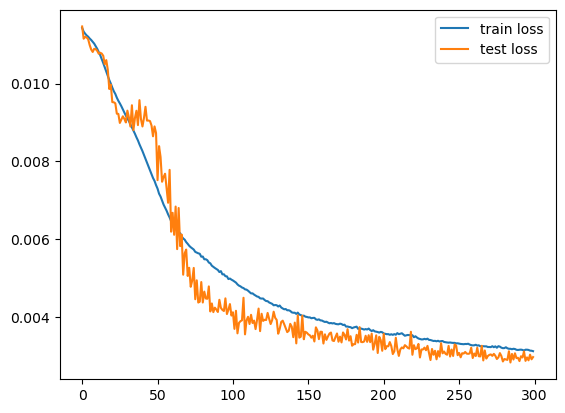

In [52]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='test loss')
plt.legend()

In [54]:
# load best model
best_model=tf.keras.models.load_model('best_model.h5')

In [55]:
Ptrain=model.predict(Xtrain_m)
Ptest=model.predict(Xtest_m)

1/1 [==============================] - 0s 49ms/step


In [56]:
# save multi-output forecast to dataframe
df.loc[test_idx,'multioutput2']=last_train+np.cumsum(Ptest)

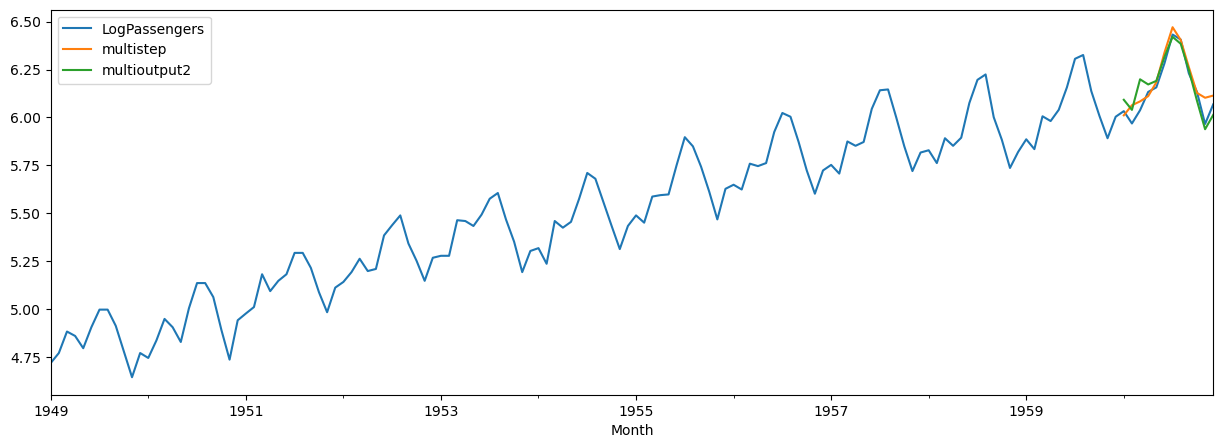

In [57]:
# Plot all foreacasts
cols=['LogPassengers','multistep','multioutput2']
df[cols].plot(figsize=(15,5));

In [58]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1=mean_absolute_percentage_error(
test_log_pass,df.loc[test_idx,'multistep'])
print('multi-step MAPE:',mape1)
mape2=mean_absolute_percentage_error(
test_log_pass,df.loc[test_idx,'multioutput'])
print('multi-output MAPE:',mape2)
mape3=mean_absolute_percentage_error(
test_log_pass,df.loc[test_idx,'multioutput2'])
print('multi-output(2 LSMs) MAPE:',mape3)

multi-step MAPE: 0.007234893848676381
multi-output MAPE: 0.003893986607056287
multi-output(2 LSMs) MAPE: 0.007902422714669548
